# Compute monthly SIC files from daily OSI SAF SIC files

In [1]:
import os
import xarray as xr
import numpy as np
from datetime import date, datetime, timedelta, time
from dateutil import rrule, relativedelta
import uuid
from copy import copy

import json

from matplotlib import pylab as plt
from matplotlib import cm


The cell below holds all the user-provided variables needed for running the task, whether the notebook is run from the web browser or called from command line via papermill (https://papermill.readthedocs.io/en/latest/index.html).

Needed parameters:
* **date** : any day in the month we want to compute monthly SIC for (type: 'YYYYMM', 'YYYYMMDD', or a datetime.date object)
* **area** : hemisphere (type: 'nh' or 'sh')
* **outdir** : where to write the monthly file. Must exist. (type: str)
* **indirs** : name of a json file containing directory paths for where to find the input daily SIC files. If None (default), the daily SIC files are accessed from THREDDS/OpenDAP

```{note}
All parameters must be set in the cell below, so that we can control the execution via papermill
```


In [2]:
dt = date(2023,3,12)
area = 'nh'
outdir = '.'
indirs = None

In [3]:
# handle datestring format and conversion
if not isinstance(dt, date):
    if isinstance(dt,str):
        if len(dt) == 6:
            dt += '16'
        if len(dt) != 8:
            raise ValueError("Datestring should br YYYYMM or YYYYMMDD")
        try:
            yyyy,mm,dd = int(dt[:4]),int(dt[4:6]),int(dt[6:8])
            dt = date(yyyy,mm,dd)
        except Exception:
            raise ValueError('Invalid datestring {}'.format(dt))

# check area parameter
if area not in ('nh', 'sh'):
    raise ValueError('Invalid hemisphere (area={})'.format(area))
    
# check outdir exists
if not os.path.exists(outdir):
    raise ValueError('Output directory does not exist ({})'.format(outdir))

# check if the JSON file for input paths exists (if provided)
if indirs is not None and not os.path.exists(indirs):
    raise ValueError('Indirs (JSON file with path to input directories) does not exist ({})'.format(indirs))

### Configure search paths for the daily SIC files

The default behaviour (indirs = None) is to search for daily SIC files available from the met.no THREDDS server. This will work for all users.

If the daily SIC files are accessible on local disks, the paths to the input directories can be specified in a JSON file (see example prepare_monthly_osisaf_sic_opendap.json).

In [4]:
# input daily SIC files
fn_patt = 'ice_conc_{a:}_ease2-250_{c:}_{d:%Y%m%d}1200.nc'
fn_patt_src = {'cdr': 'cdr-v3p0', 'icdr': 'icdr-v3p0', 'icdrft': 'icdrft-v3p0'}

if indirs is None:
    # access through THREDDS/OpenDAP
    sources = {'cdr':'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/',
              'icdr':'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/',
              'icdrft':'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/'}
    jsond = json.dumps(sources, sort_keys=True, indent=4)
else:
    # load json file with path to input directories (if the daily SIC files are downloaded to a local disk)
    # an example json file (prepare_monthly_osisaf_sic_opendap.json) is provided to demonstrate the format
    #   expected for the json file (but the effect will be the same as setting indirs to None: read from
    #   THREDDS/opendap)
    with open(indirs, 'r') as f:
        sources = json.load(f)

### Find all daily SIC files for a month

In [5]:

def get_first_last_date(dt):
    first_day = date(dt.year,dt.month,1)
    last_day = first_day + relativedelta.relativedelta(months=1)-timedelta(days=1)
    return first_day, last_day

def find_sic_files(dt, area):

    files = []
    srcs = []
    # iterate over all days in the month
    first_day, last_day = get_first_last_date(dt)
    for d in rrule.rrule(rrule.DAILY, dtstart=first_day,
                                        until=last_day):
        # find the path/url to the file. There are precedence rules for what type of files
        #   to select.
        found_one_file = False
        for cdr in ('cdr', 'icdr', 'icdrft'):
            fn = fn_patt.format(a=area, d=d, c=fn_patt_src[cdr])
            fn = os.path.join(sources[cdr],'{:%Y/%m/}'.format(d),fn)
            try:
                # this url exists, append it and move to next date
                ds = xr.open_dataset(fn)
                found_one_file = True
                files.append(fn)
                srcs.append(cdr)
                continue
            except OSError:
                # no valid file at this url, check the next rule
                pass
        
        # no file found. Add a warning (but we can continue)
        if not found_one_file:
            print("WARNING: could not find OSI SAF SIC v3 file for {} {}".format(area, d.date()))
        
    return files, srcs

files, srcs = find_sic_files(dt, area)
print(files)
print(srcs)

['https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/2023/03/ice_conc_nh_ease2-250_icdr-v3p0_202303011200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/2023/03/ice_conc_nh_ease2-250_icdr-v3p0_202303021200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/2023/03/ice_conc_nh_ease2-250_icdr-v3p0_202303031200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/2023/03/ice_conc_nh_ease2-250_icdr-v3p0_202303041200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/2023/03/ice_conc_nh_ease2-250_icdr-v3p0_202303051200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/2023/03/ice_conc_nh_ease2-250_icdr-v3p0_202303061200.nc', 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_cra_files/2023/03/ice_conc_nh_ease2-250_icdr-v3p0_202303071200.nc', 'https://thr

### Open access to all the files

In [6]:
ds = xr.open_mfdataset(files,)
print(ds)

<xarray.Dataset>
Dimensions:                         (time: 31, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                            (time) datetime64[ns] 2023-03-01T12:00:00...
  * xc                              (xc) float64 -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 5.388e+03 ... -5.388e+03
    lat                             (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon                             (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid          (time) int32 -2147483647 ... -2147483647
    time_bnds                       (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    ice_conc                        (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    raw_ice_conc_values             (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
   

### Compute monthly average SIC

This requires re-combining the filtered SIC in 'ice_conc' with the unfiltered values in 'raw_ice_conc_values'. We use the 'status_flag' variable.

In [7]:
# A routine to reconstruct the unfiltered, unthresholded SICs from a OSI SAF SIC CDR file
def reconstruct_sic(ds):
    ice_conc = ds['ice_conc'].to_masked_array()
    raw_ice_conc_values = ds['raw_ice_conc_values'].to_masked_array()
    status_flag = ds['status_flag'].to_masked_array().astype('short')
    
    # combine ice_conc with raw_ice_conc_values using the status_flag
    new_ice_conc = copy(ice_conc)
    raw_100_mask = np.array((ice_conc==100) * (~raw_ice_conc_values.mask))
    new_ice_conc[raw_100_mask] = raw_ice_conc_values[raw_100_mask]
    
    new_ice_conc[(status_flag & 4) == 4] = raw_ice_conc_values[(status_flag & 4) == 4]

    # re-enter "full" ice_conc into the xarray dataset
    ds['ice_conc'][:] = new_ice_conc
    return ds

In [8]:
ds = reconstruct_sic(ds)

Use xarray to compute the mean over time (now that we replaced the ice_conc)

In [9]:
ds_month = ds.mean(dim="time", keep_attrs=True)
ds_month

<xarray.Dataset>
Dimensions:                         (xc: 432, yc: 432)
Coordinates:
  * xc                              (xc) float64 -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 5.388e+03 ... -5.388e+03
    lat                             (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon                             (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Data variables:
    Lambert_Azimuthal_Grid          float64 -2.147e+09
    ice_conc                        (yc, xc) float64 dask.array<chunksize=(432, 432), meta=np.ndarray>
    raw_ice_conc_values             (yc, xc) float64 dask.array<chunksize=(432, 432), meta=np.ndarray>
    total_standard_uncertainty      (yc, xc) float64 dask.array<chunksize=(432, 432), meta=np.ndarray>
    smearing_standard_uncertainty   (yc, xc) float64 dask.array<chunksize=(432, 432), meta=np.ndarray>
    algorithm_standard_uncertainty  (yc, xc) float64 dask.array<chunksize=(432, 432), meta=np.ndarray>
    status_flag                     (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Attributes: (12/44)
    title:                           Interim Sea Ice Concentration Climate Da...
    summary:                         This Interim Climate Data Record impleme...
    topiccategory:                   Oceans ClimatologyMeteorologyAtmosphere
    keywords:                        GCMDSK:Earth Science > Cryosphere > Sea ...
    keywords_vocabulary:             GCMDSK:GCMD Science Keywords:https://gcm...
    geospatial_lat_min:              16.62393
    ...                              ...
    standard_name_vocabulary:        CF Standard Name Table (Version 78, 21 S...
    product_id:                      osi-430-a
    product_name:                    osi_saf_sea_ice_conc_climate_data_record...
    product_status:                  operational
    doi:                             10.15770/EUM_SAF_OSI_0014
    DODS_EXTRA.Unlimited_Dimension:  time

Re-arrange SIC values into 'ice_conc' and 'raw_ice_conc_values'

In [10]:
ice_conc = ds_month['ice_conc'].to_masked_array()
raw_ice_conc_values = np.ma.array(np.zeros_like(ice_conc).astype(ice_conc.dtype),
                                  mask=np.ones_like(ice_conc).astype('bool'))
index = ice_conc>100
raw_ice_conc_values[index] = ice_conc[index]
ice_conc[index] = 100

owf = ice_conc<10
raw_ice_conc_values[owf] = ice_conc[owf]
ice_conc[owf] = 0

Prepare a simplified 'status_flag' variable. We only keep '1' (land) and '128' (climatology). The rest we set to '0' (nominal) of '4' (open water filter). 

In [11]:
status_flag = ds['status_flag'][0].to_masked_array().astype('short')
index = (status_flag != 1)*(status_flag != 128)
status_flag[index] = 0

# empty 'raw_ice_conc_values' over climatology (as in the daily files)
raw_ice_conc_values[status_flag == 128] = np.ma.masked

# store '4' (OWF) in the status_flag where we have raw_ice_conc_values over water (SIC < 10%)
status_flag[owf*(status_flag != 128)] = 4

In [12]:
# store monthly mean ice_conc, raw_ice_conc_values, and status_flags back in the xarray structure
ds_month['raw_ice_conc_values'][:] = raw_ice_conc_values
ds_month['ice_conc'][:] = ice_conc
ds_month['status_flag'][:] = status_flag

### Clean the xarray dataset structure and write to file

In [13]:
ds_month = ds_month.drop_vars( ('total_standard_uncertainty', 'smearing_standard_uncertainty', 'algorithm_standard_uncertainty',) )

The filename should reflect what type of daily SIC files were used as input. If only 'cdr' files were used, the monthly file should have 'cdr'. If only 'icdr' files were used, the monthly files should have 'icdr'. If some fast-track ICDR files ('icdrft') were used, this should also be in the name of the monthly file.

In [14]:
# Amend some attributes
first_day, last_day = get_first_last_date(dt)
ds_month.attrs['time_coverage_start'] = datetime.combine(first_day, time()).isoformat()+'Z'
ds_month.attrs['time_coverage_end'] = (datetime.combine(last_day,time())+timedelta(days=1)).isoformat()+'Z'

ds_month.attrs['time_coverage_duration'] = 'P1M'
ds_month.attrs['time_coverage_resolution'] = 'P1M'

now = datetime.utcnow().replace(microsecond=0)
ds_month.attrs['history'] = now.isoformat()+'Z' + ' creation'
ds_month.attrs['date_created'] = now.date().isoformat()

ds_month.attrs['tracking_id'] = str(uuid.uuid4())

ds_month.attrs['title'] = 'Monthly ' + ds_month.attrs['title']

In [15]:
# Open one of the original files to extract information like dtype, _FillValue, time units, etc...
dso = xr.open_dataset(files[0],mask_and_scale=False,decode_times=False)
dso



<xarray.Dataset>
Dimensions:                         (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                            (time) float64 1.425e+09
  * xc                              (xc) float64 -5.388e+03 ... 5.388e+03
  * yc                              (yc) float64 5.388e+03 ... -5.388e+03
    lat                             (yc, xc) float32 ...
    lon                             (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid          int32 ...
    time_bnds                       (time, nv) float64 ...
    ice_conc                        (time, yc, xc) int32 ...
    raw_ice_conc_values             (time, yc, xc) int32 ...
    total_standard_uncertainty      (time, yc, xc) int32 ...
    smearing_standard_uncertainty   (time, yc, xc) int32 ...
    algorithm_standard_uncertainty  (time, yc, xc) int32 ...
    status_flag                     (time, yc, xc) int16 ...
Attributes: (12/44)
    title:                           Interim Sea Ice Concentration Climate Da...
    summary:                         This Interim Climate Data Record impleme...
    topiccategory:                   Oceans ClimatologyMeteorologyAtmosphere
    keywords:                        GCMDSK:Earth Science > Cryosphere > Sea ...
    keywords_vocabulary:             GCMDSK:GCMD Science Keywords:https://gcm...
    geospatial_lat_min:              16.62393
    ...                              ...
    standard_name_vocabulary:        CF Standard Name Table (Version 78, 21 S...
    product_id:                      osi-430-a
    product_name:                    osi_saf_sea_ice_conc_climate_data_record...
    product_status:                  operational
    doi:                             10.15770/EUM_SAF_OSI_0014
    DODS_EXTRA.Unlimited_Dimension:  time

Add 'time' dimension and coordinate variable (the 16th of the month).

In addition, add the 'time_bnds' variable, which requires the 'nv' dimension. time_bnds[0] gets the first day of the month (0 utc), time_bnds[1] gets the first day of the following month (0 utc).

This turned out to be a bit messy, suggestions for improvements are welcome.

In [16]:
# Prepare the time_bnds variable [start, end] and it as a data variable to the dataset.
time_bnds = [np.datetime64(ds_month.attrs['time_coverage_start'][:-1]),np.datetime64(ds_month.attrs['time_coverage_end'][:-1])]
time_bnds_da = xr.DataArray(time_bnds, [('nv', time_bnds,)])

# For some reasons, ds.assign brings a coordinate variable 'nv' that we must remove.
ds_month = ds_month.assign(time_bnds=time_bnds_da)
ds_month = ds_month.drop(labels='nv')
ds_month

<xarray.Dataset>
Dimensions:                 (xc: 432, yc: 432, nv: 2)
Coordinates:
  * xc                      (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon                     (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid  float64 -2.147e+09
    ice_conc                (yc, xc) float64 dask.array<chunksize=(432, 432), meta=np.ndarray>
    raw_ice_conc_values     (yc, xc) float64 dask.array<chunksize=(432, 432), meta=np.ndarray>
    status_flag             (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    time_bnds               (nv) datetime64[ns] 2023-03-01 2023-04-01
Attributes: (12/44)
    title:                           Monthly Interim Sea Ice Concentration Cl...
    summary:                         This Interim Climate Data Record impleme...
    topiccategory:                   Oceans ClimatologyMeteorologyAtmosphere
    keywords:                        GCMDSK:Earth Science > Cryosphere > Sea ...
    keywords_vocabulary:             GCMDSK:GCMD Science Keywords:https://gcm...
    geospatial_lat_min:              16.62393
    ...                              ...
    standard_name_vocabulary:        CF Standard Name Table (Version 78, 21 S...
    product_id:                      osi-430-a
    product_name:                    osi_saf_sea_ice_conc_climate_data_record...
    product_status:                  operational
    doi:                             10.15770/EUM_SAF_OSI_0014
    DODS_EXTRA.Unlimited_Dimension:  time

In [17]:
# Prepare the time coordinate
mid_time = [np.datetime64('{:%Y-%m-16 12:00:00}'.format(dt)),]
mid_time_da = xr.DataArray(mid_time, [('time', mid_time,)])

mid_time_da

<xarray.DataArray (time: 1)>
array(['2023-03-16T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2023-03-16T12:00:00

In [18]:
# add the 'time' coordinate variable (and dimension) to the dataset object
dst_month = ds_month.expand_dims(time=mid_time_da)

# drop time dimension for the CRS (added by expand_dims)
dst_month['Lambert_Azimuthal_Grid'] = dst_month['Lambert_Azimuthal_Grid'].squeeze(dim='time',drop=True)

# assign original attributes, but not 'units' nor 'calendar' as these
#   are re-introduced by xarray as encoding (not attributes) at time of
#   writing to netCDF
time_attrs = copy(dso.time.attrs)
time_attrs.pop('units',None)
time_attrs.pop('calendar',None)
for k in list(time_attrs.keys()):
    if k.startswith('_'):
        time_attrs.pop(k, None)
dst_month.time.attrs = time_attrs
dst_month

<xarray.Dataset>
Dimensions:                 (time: 1, xc: 432, yc: 432, nv: 2)
Coordinates:
  * time                    (time) datetime64[ns] 2023-03-16T12:00:00
  * xc                      (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lon                     (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid  float64 -2.147e+09
    ice_conc                (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    raw_ice_conc_values     (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    status_flag             (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>
    time_bnds               (time, nv) datetime64[ns] 2023-03-01 2023-04-01
Attributes: (12/44)
    title:                           Monthly Interim Sea Ice Concentration Cl...
    summary:                         This Interim Climate Data Record impleme...
    topiccategory:                   Oceans ClimatologyMeteorologyAtmosphere
    keywords:                        GCMDSK:Earth Science > Cryosphere > Sea ...
    keywords_vocabulary:             GCMDSK:GCMD Science Keywords:https://gcm...
    geospatial_lat_min:              16.62393
    ...                              ...
    standard_name_vocabulary:        CF Standard Name Table (Version 78, 21 S...
    product_id:                      osi-430-a
    product_name:                    osi_saf_sea_ice_conc_climate_data_record...
    product_status:                  operational
    doi:                             10.15770/EUM_SAF_OSI_0014
    DODS_EXTRA.Unlimited_Dimension:  time

In [19]:
# uniqued list of daily CDR sources
srcs = sorted(list(set(srcs)))

# monthly file name (note the format of the datestring: YYYYMM.nc)
fn_patt = 'ice_conc_{a:}_ease2-250_{c:}-v3p0_{d:%Y%m}.nc'
fn = fn_patt.format(a=area, d=dt, c=srcs[-1])
fn = os.path.join(outdir,fn)

# encoding
encoding = {'time': {'dtype':dso['time'].dtype, 'units':dso['time'].units, 'calendar':dso['time'].calendar,'_FillValue':None},
            'time_bnds': {'dtype':dso['time_bnds'].dtype,'units':dso['time_bnds'].units,'_FillValue':None},
            'ice_conc': {'dtype':dso['ice_conc'].dtype, 'scale_factor':dso['ice_conc'].scale_factor, '_FillValue':dso['ice_conc']._FillValue},
            'raw_ice_conc_values': {'dtype':dso['raw_ice_conc_values'].dtype, 'scale_factor':dso['raw_ice_conc_values'].scale_factor, '_FillValue':dso['raw_ice_conc_values']._FillValue},
            'status_flag': {'dtype':dso['status_flag'].dtype, '_FillValue':dso['status_flag']._FillValue},
            'lat': {'_FillValue':None}, 'lon': {'_FillValue':None},
            'xc': {'_FillValue':None}, 'yc': {'_FillValue':None},
            'Lambert_Azimuthal_Grid': {'_FillValue':None, 'dtype':dso['Lambert_Azimuthal_Grid'].dtype}
           }

for v in encoding.keys():
    encoding[v]['zlib']=True

# save the monthly xarray dataset to file
if os.path.exists(fn):
    os.remove(fn)
dst_month.to_netcdf(fn, encoding=encoding, format="NETCDF4_CLASSIC")

print(fn + ' ready')

/tmp/ipykernel_170127/2461236189.py:26: SerializationWarning: saving variable Lambert_Azimuthal_Grid with floating point data as an integer dtype without any _FillValue to use for NaNs
  dst_month.to_netcdf(fn, encoding=encoding, format="NETCDF4_CLASSIC")


./ice_conc_nh_ease2-250_icdr-v3p0_202303.nc ready


## Re-open and plot the content of the file for checking

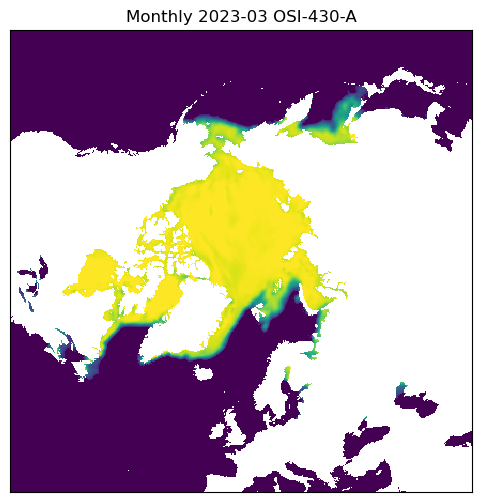

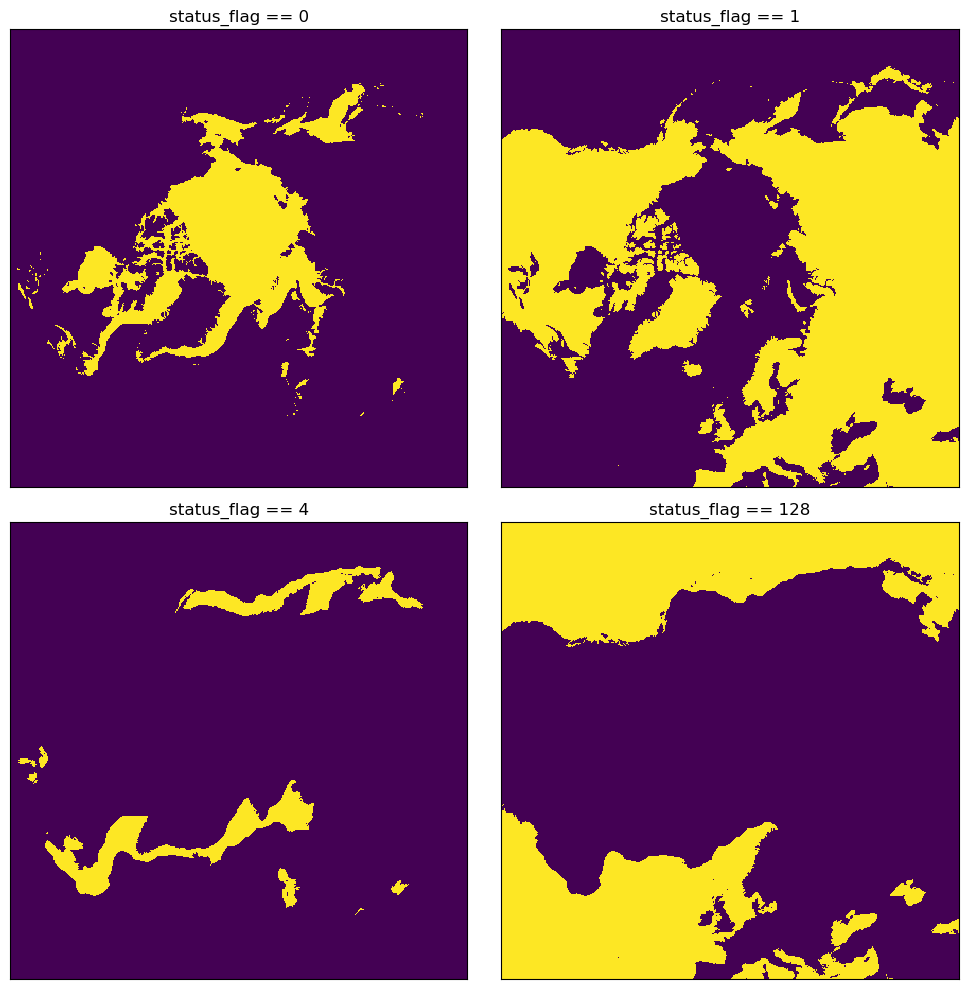

In [20]:
ds = xr.open_dataset(fn)

from matplotlib import pylab as plt
fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(ds['ice_conc'][0], interpolation='none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Monthly {} {}'.format(np.datetime_as_string(ds['time'].data[0],unit='M'), ds.product_id.upper()))
plt.show()



sflags = [0,1,4,128,]
fig, axs = plt.subplots(2,2,figsize=(10,10))
for isf, sf in enumerate(sflags):
    i,j = np.unravel_index(isf, axs.shape)
    axs[i,j].imshow(ds['status_flag'][0]==sf, interpolation='none')
    axs[i,j].set_title('status_flag == {}'.format(sf))
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])

plt.tight_layout()
plt.show()